# Uploading and reading data
Before running this script, upload the data from kaggle to colab

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#import csv: UPLOAD DATA TO COLAB FIRST!
train_df = pd.read_csv('sales_train.csv')
items_df = pd.read_csv('items.csv')
item_categories_df = pd.read_csv('item_categories.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')
shops_df = pd.read_csv('shops.csv')
test_df = pd.read_csv('test.csv')




# Checking the data
After checking:
- **train_df** is the training data
- **items_df** is only metadata with item information. I guess we won't need it in the progress
- **item_categories_df** is metadata aswell
- **sample_submission_df** shows how to submit the results
- **shops_df** is metadata with shop information
- **test_df** is data on which we will predict future sales

In [ ]:
#How does the df look like
print(train_df.head())
print(train_df.info())
train_df.isnull().sum()


         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


,0
date,0
date_block_num,0
shop_id,0
item_id,0
item_price,0
item_cnt_day,0


# Data Manipulation
- Getting monthly sales from the daily sales (Be aware that date_block_num Jan=0 vs. month = 01)

In [ ]:

train_df['year'] = train_df.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').strftime('%Y'))
train_df['month'] = train_df.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').strftime('%m'))

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
print(train_df.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  year month
0  02.01.2013               0       59    22154      999.00           1.0  2013    01
1  03.01.2013               0       25     2552      899.00           1.0  2013    01
2  05.01.2013               0       25     2552      899.00          -1.0  2013    01
3  06.01.2013               0       25     2554     1709.05           1.0  2013    01
4  15.01.2013               0       25     2555     1099.00           1.0  2013    01


# Data Visualization
Let's take a look at the data and get a first look at what we want to analyze. Maybe we see some trends, problems, outliers or something else we have to consider

   date_block_num  item_cnt_day
0               0      131479.0
1               1      128090.0
2               2      147142.0
3               3      107190.0
4               4      106970.0


Text(0, 0.5, 'Total sales')

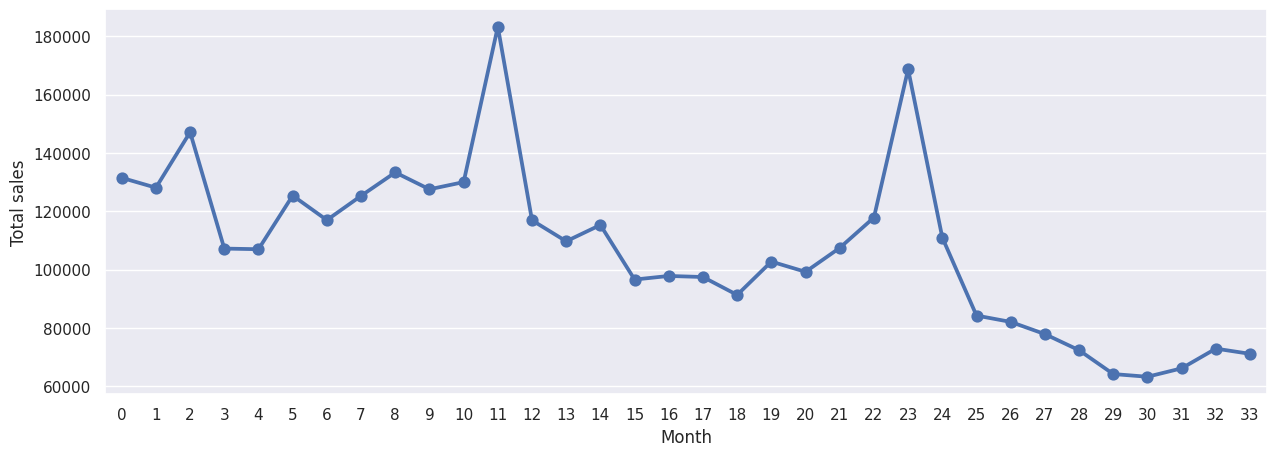

In [ ]:
%matplotlib inline

Plot_data = pd.DataFrame(train_df.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index())
print(Plot_data.head())
sns.set_theme(rc={'figure.figsize':(15,5)})
sns.pointplot(x='date_block_num', y='item_cnt_day', data=Plot_data)
plt.xlabel('Month')
plt.ylabel('Total sales')

It seems like total sales are are declining, and we have some big spikes around christmas time. So there are definitely some seasonal trends.

Let's take a look at the item price. We can't just sum up all the item prices, so we will take the mean of the item prices.

Text(0, 0.5, 'Average item price')

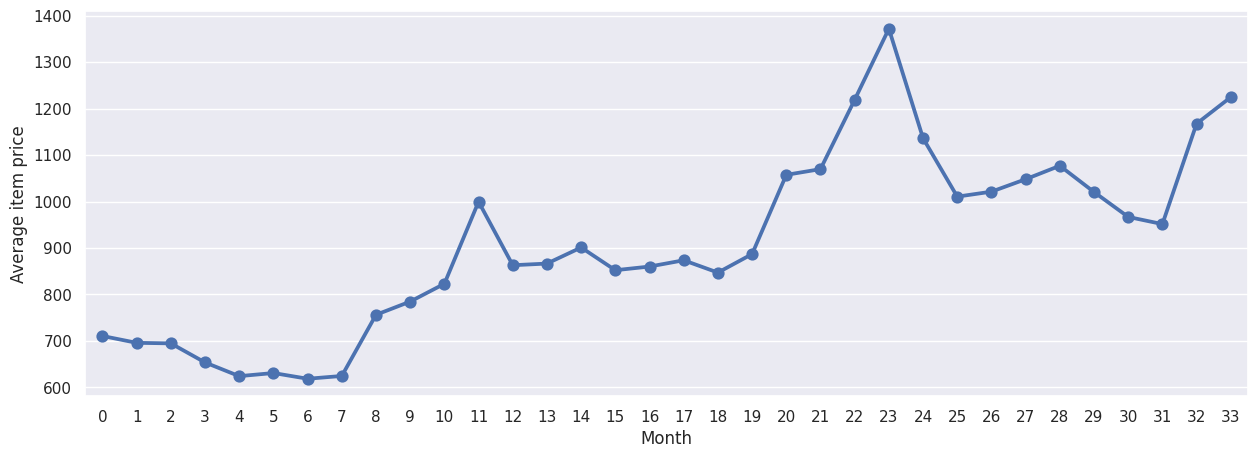

In [ ]:
%matplotlib inline

Plot_data2 = pd.DataFrame(train_df.groupby(['date_block_num'])['item_price'].mean().reset_index())
sns.set_theme(rc={'figure.figsize':(15,5)})
sns.pointplot(x='date_block_num', y='item_price', data=Plot_data2)
plt.xlabel('Month')
plt.ylabel('Average item price')

 As you would guess: Prices are rising and sales are declining. Does look pretty normal.

 Next let's see if there is the need to purge some outliers.

<Figure size 700x700 with 0 Axes>

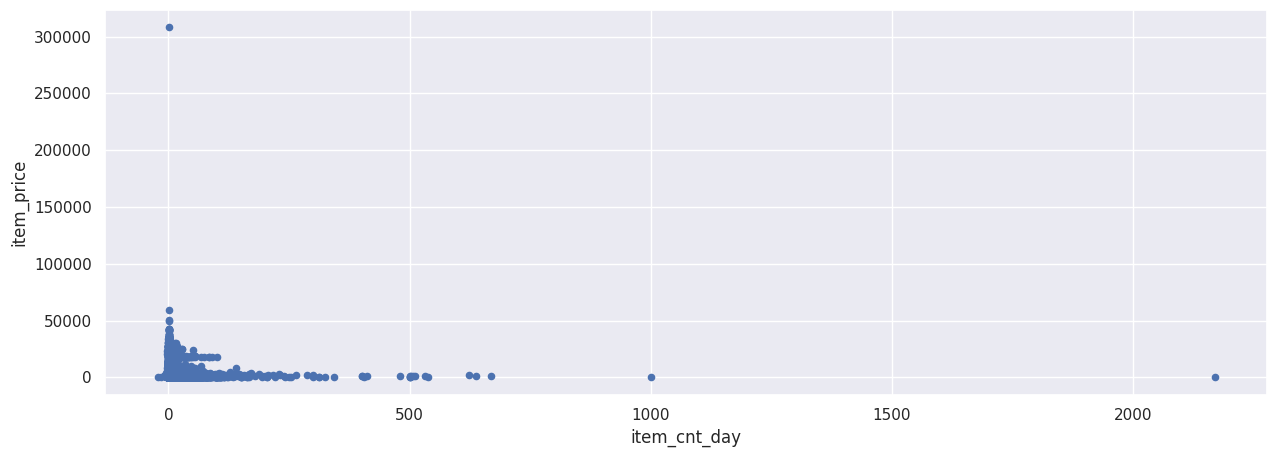

In [ ]:
plt.figure(figsize=(7,7))
train_df.plot.scatter(x = 'item_cnt_day', y='item_price')
plt.show()

# Data Cleaning

It seems like we have some outliers with an item price more than 300k and some items which were sold more than 2000 times in one day. In the next step we should remove them. Removing these points won't cause problems with the results submission, because we will do our final prediction on the test data set.


In [ ]:
old_length = train_df.shape[0]
train_df = train_df.query('item_price > 0')
new_length = train_df.shape[0]

print('Removed ', old_length - new_length,'items from dataframe train_df')

Removed  1 items from dataframe train_df


One outlier with an item price of 0 has been removed. Let's remove the outliers in item_cnt_day where more than 350 are sold. This should kick the big outliers from the scatterplot.

In [ ]:
old_length2 = train_df.shape[0]
train_df = train_df.query('item_cnt_day < 350')
new_length = train_df.shape[0]

print('Removed ', old_length - new_length,'items from dataframe train_df' )

Removed  20 items from dataframe train_df


20 Outliers with more than 350 sales have been removed.

In  the next step, kick all items from the dataframe that do not have the same shops or items as the test dataframe

In [ ]:
old_length3 = train_df.shape[0]

matched_train_df = train_df[train_df['shop_id'].isin(test_df['shop_id'].unique())]
matched_train_df = matched_train_df[matched_train_df['item_id'].isin(test_df['item_id'].unique())]

new_length = matched_train_df.shape[0]

print('Removed ', old_length - new_length,'items from dataframe train_df' )



Removed  1711419 items from dataframe train_df


1711419 items have been removed and the training data should now be 'clean' and ready for the model. Let's take a look at the new data and recreate the old plots:

<Figure size 700x700 with 0 Axes>

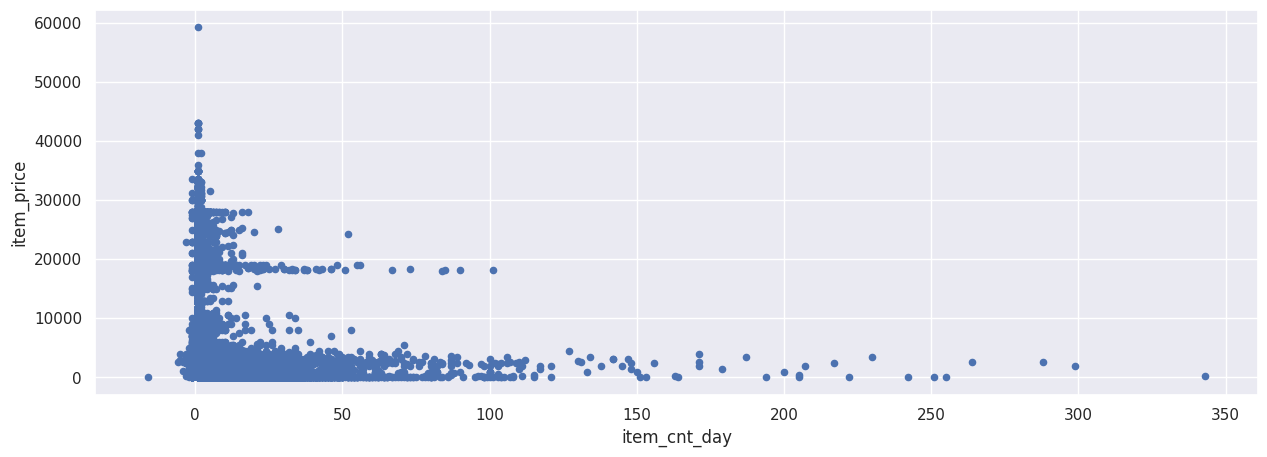

In [ ]:
plt.figure(figsize=(7,7))
matched_train_df.plot.scatter(x = 'item_cnt_day', y='item_price')
plt.show()

Still looks like too many outliers, lets create a boxplot to identify more outliers:

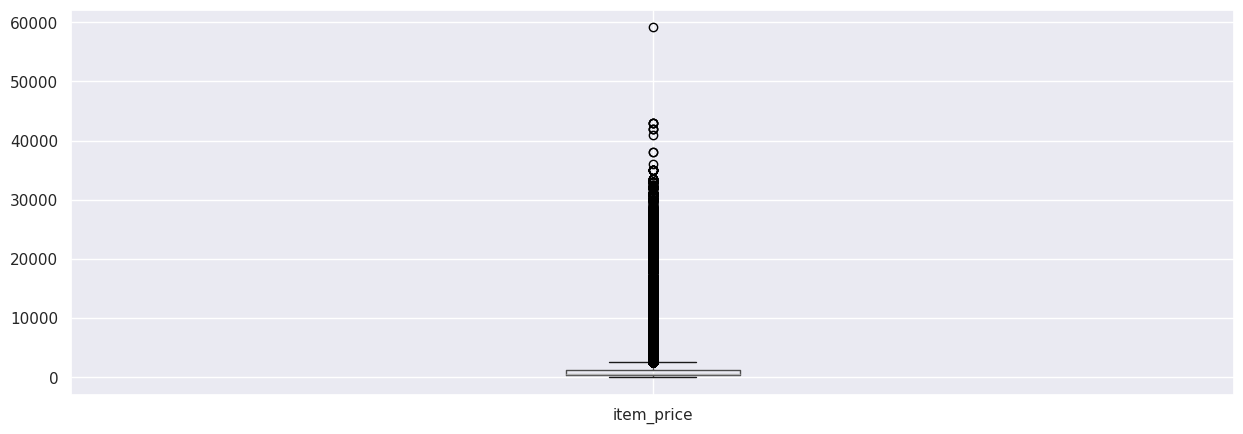

In [ ]:
boxplot = matched_train_df.boxplot(column=['item_price'])
plt.show()

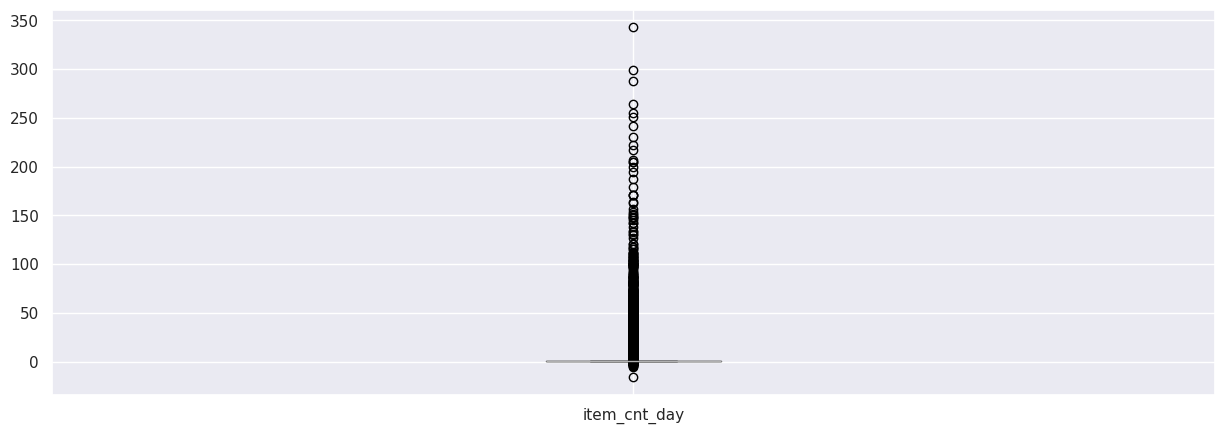

In [ ]:
boxplot = matched_train_df.boxplot(column=['item_cnt_day'])
plt.show()

The Boxplot shows a lot of extreme points, so it will be ok to kick some more. Because sales are not some natural and there are a lot of trends it won't be good to kick all of them. But lets clean the data set a bit more.

In [ ]:
old_length4 = matched_train_df.shape[0]
matched_train_df = matched_train_df.query('item_price < 35000')
matched_train_df = matched_train_df.query('item_cnt_day < 170')
new_length = matched_train_df.shape[0]

print('Removed ', old_length4 - new_length,'items from dataframe train_df' )

Removed  32 items from dataframe train_df


Kicked 32 more outliers from the data set

# Data Visualization after cleaning

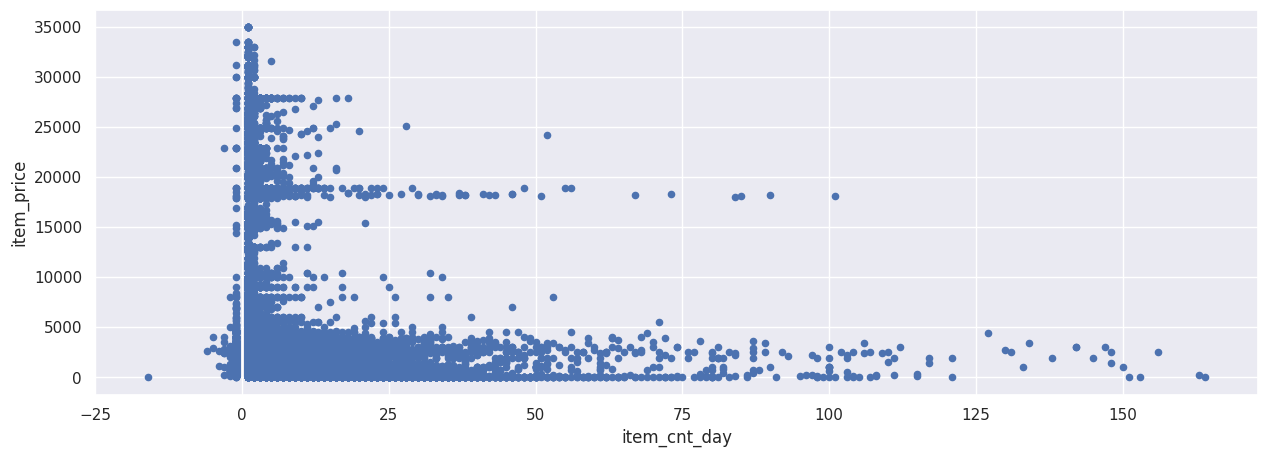

<Figure size 700x700 with 0 Axes>

In [ ]:
matched_train_df.plot.scatter(x = 'item_cnt_day', y='item_price')
plt.figure(figsize=(7,7))
plt.show()

It looks better now, we can use this for the model. Also nice to see, that there are days, where items were returned to the store. You can see
*item_cnt_days* with negative values.

Text(0, 0.5, 'Total sales')

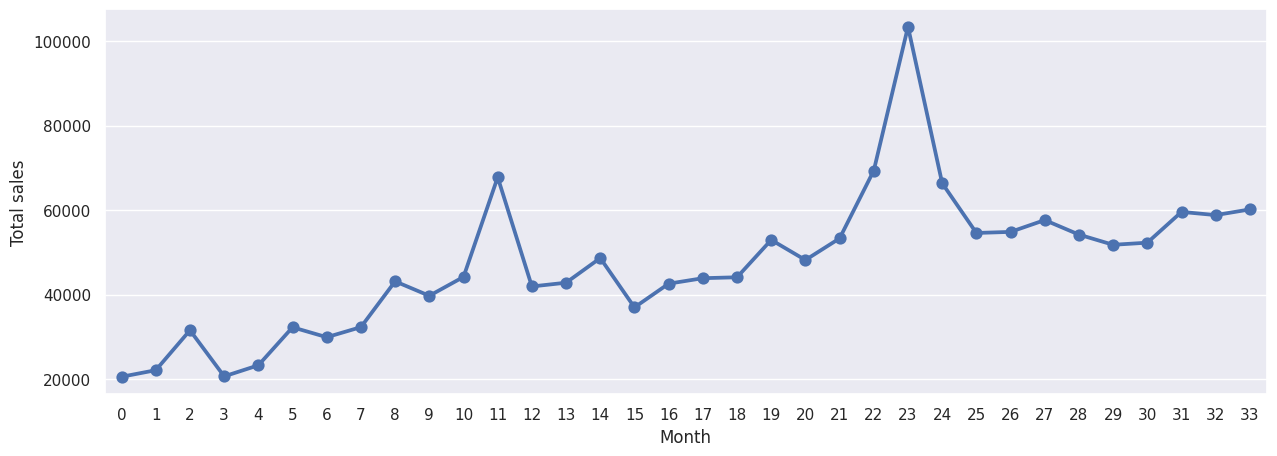

In [ ]:
%matplotlib inline

Plot_data = pd.DataFrame(matched_train_df.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index())
sns.set_theme(rc={'figure.figsize':(15,5)})
sns.pointplot(x='date_block_num', y='item_cnt_day', data=Plot_data)
plt.xlabel('Month')
plt.ylabel('Total sales')

**Ok that's pretty interesting: After reducing the training dataset to the relevant data by matching it with the test data and by reducing outliers the total sales are not decreasing anymore. The are increasing now, we can guess that this will affect the model quality!**

Text(0, 0.5, 'Average item price')

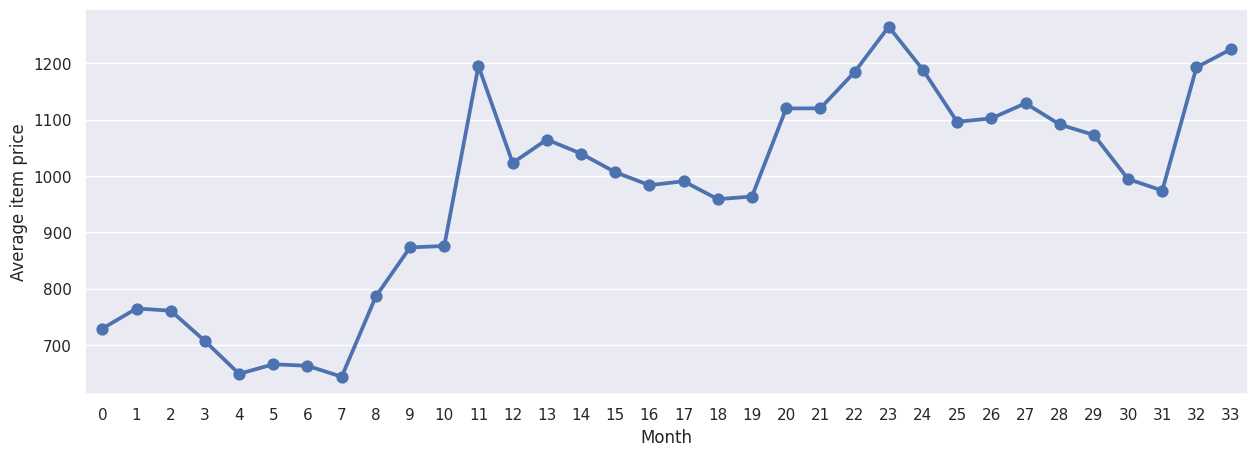

In [ ]:
%matplotlib inline

Plot_data = pd.DataFrame(matched_train_df.groupby(['date_block_num'])['item_price'].mean().reset_index())
sns.set_theme(rc={'figure.figsize':(15,5)})
sns.pointplot(x='date_block_num', y='item_price', data=Plot_data)
plt.xlabel('Month')
plt.ylabel('Average item price')

Average item price is still increasing, so far so good.

In [ ]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
print(matched_train_df.head())


          date  date_block_num  shop_id  item_id  item_price  item_cnt_day  year month
0   02.01.2013               0       59    22154       999.0           1.0  2013    01
10  03.01.2013               0       25     2574       399.0           2.0  2013    01
11  05.01.2013               0       25     2574       399.0           1.0  2013    01
12  07.01.2013               0       25     2574       399.0           1.0  2013    01
13  08.01.2013               0       25     2574       399.0           2.0  2013    01


# Data preparation for the Model
First we need to calculate the monthly sales for each item in each shop:

In [ ]:
training_data = matched_train_df.groupby(['date_block_num', 'shop_id', 'item_id'])[
    ['date_block_num', 'date', 'item_price', 'item_cnt_day']].agg({
        'date_block_num': 'mean',
        'date': ['min', 'max'],
        'item_price': 'mean',
        'item_cnt_day': 'sum'
    })

training_data.head()

date_block_num        date             item_price item_cnt_day
                                         mean         min         max       mean          sum
date_block_num shop_id item_id                                                               
0              2       33                 0.0  05.01.2013  05.01.2013      499.0          1.0
                       482                0.0  16.01.2013  16.01.2013     3300.0          1.0
                       491                0.0  09.01.2013  09.01.2013      600.0          1.0
                       839                0.0  22.01.2013  22.01.2013     3300.0          1.0
                       1007               0.0  11.01.2013  25.01.2013      449.0          3.0

Then we have to bring it into the same format as the test dataframe/submission dataframe by merging it

In [ ]:
training_data2 = training_data.item_cnt_day.apply(list).reset_index()

training_data2 = pd.merge(test_df,training_data2,on = ['item_id','shop_id'],how = 'left')
#fill na with 0
training_data2.fillna(0,inplace = True)
training_data2.drop(['shop_id','item_id'],inplace = True, axis = 1)

len(training_data2)
training_data2.head()

,ID,date_block_num,sum
0,0,20.0,1.0
1,0,22.0,1.0
2,0,23.0,2.0
3,0,24.0,2.0
4,0,28.0,1.0


Now we create the matrix so we can feed it into the LSTM: in the rows we have the ID which is the Combination of shop + item as in the submission file.
The Colums will be the date_num_block

In [ ]:
train_matrix = training_data2.pivot_table(index='ID', columns='date_block_num',fill_value = 0,aggfunc='sum' )
train_matrix.head()


sum                                                                                                                                                                     
date_block_num 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0
ID                                                                                                                                                                                      
0               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  2.0  2.0  0.0  0.0  0.0  1.0  1.0  1.0  3.0  1.0  0.0
1               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  2.0  0.0  1.0  3.0  1.0
3               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
4               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Let's check if everything went right and they still have the same format. Look's good!

In [ ]:
print(len(train_matrix))
print(len(test_df))
test_df.head()

214200
214200


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


#Feauture Engineering
For better predicitons we will need to create more useful features. It's possible, that the sales in a specific month depend from the sales of the previous month or the year before. So we will create some time-lags.

In [ ]:
lag0 = train_matrix.T.copy();

#1 month lag
lag1 = lag0.shift(1,axis=0);lag1.fillna(0,inplace = True);
lag1.index = lag1.index.map(lambda x: (x[0], str(x[1]) + '_lag1'))

#2 month lag
lag2 = lag0.shift(2,axis=0);lag2.fillna(0,inplace = True);
lag2.index = lag2.index.map(lambda x: (x[0], str(x[1]) + '_lag2'))

#3 month lag
lag3 = lag0.shift(3,axis=0);lag3.fillna(0,inplace = True);
lag3.index = lag3.index.map(lambda x: (x[0], str(x[1]) + '_lag3'))

#12 month = 1 year lag for seasonal effect
lag12 = lag0.shift(12,axis=0);lag12.fillna(0,inplace = True);
lag12.index = lag12.index.map(lambda x: (x[0], str(x[1]) + '_lag12'))


train_matrix_with_lag = pd.concat((lag0,lag1,lag2,lag3,lag12),axis=0).T;
train_matrix_with_lag = train_matrix_with_lag.reset_index()
train_matrix_with_lag = train_matrix_with_lag.rename_axis('original_index')
train_matrix_with_lag = train_matrix_with_lag.set_index('ID')
column_level_names = train_matrix_with_lag.columns.names
train_matrix_with_lag.columns = train_matrix_with_lag.columns.to_flat_index()
train_matrix_with_lag.columns = ['_'.join(str(s) for s in col) for col in train_matrix_with_lag.columns]
train_matrix_with_lag.head()

,sum_0.0,sum_1.0,sum_2.0,sum_3.0,sum_4.0,sum_5.0,sum_6.0,sum_7.0,sum_8.0,sum_9.0,sum_10.0,sum_11.0,sum_12.0,sum_13.0,sum_14.0,sum_15.0,sum_16.0,sum_17.0,sum_18.0,sum_19.0,sum_20.0,sum_21.0,sum_22.0,sum_23.0,sum_24.0,sum_25.0,sum_26.0,sum_27.0,sum_28.0,sum_29.0,sum_30.0,sum_31.0,sum_32.0,sum_33.0,sum_0.0_lag1,sum_1.0_lag1,sum_2.0_lag1,sum_3.0_lag1,sum_4.0_lag1,sum_5.0_lag1,sum_6.0_lag1,sum_7.0_lag1,sum_8.0_lag1,sum_9.0_lag1,sum_10.0_lag1,sum_11.0_lag1,sum_12.0_lag1,sum_13.0_lag1,sum_14.0_lag1,sum_15.0_lag1,sum_16.0_lag1,sum_17.0_lag1,sum_18.0_lag1,sum_19.0_lag1,sum_20.0_lag1,sum_21.0_lag1,sum_22.0_lag1,sum_23.0_lag1,sum_24.0_lag1,sum_25.0_lag1,sum_26.0_lag1,sum_27.0_lag1,sum_28.0_lag1,sum_29.0_lag1,sum_30.0_lag1,sum_31.0_lag1,sum_32.0_lag1,sum_33.0_lag1,sum_0.0_lag2,sum_1.0_lag2,sum_2.0_lag2,sum_3.0_lag2,sum_4.0_lag2,sum_5.0_lag2,sum_6.0_lag2,sum_7.0_lag2,sum_8.0_lag2,sum_9.0_lag2,sum_10.0_lag2,sum_11.0_lag2,sum_12.0_lag2,sum_13.0_lag2,sum_14.0_lag2,sum_15.0_lag2,sum_16.0_lag2,sum_17.0_lag2,sum_18.0_lag2,sum_19.0_lag2,sum_20.0_lag2,sum_21.0_lag2,sum_22.0_lag2,sum_23.0_lag2,sum_24.0_lag2,sum_25.0_lag2,sum_26.0_lag2,sum_27.0_lag2,sum_28.0_lag2,sum_29.0_lag2,sum_30.0_lag2,sum_31.0_lag2,sum_32.0_lag2,sum_33.0_lag2,sum_0.0_lag3,sum_1.0_lag3,sum_2.0_lag3,sum_3.0_lag3,sum_4.0_lag3,sum_5.0_lag3,sum_6.0_lag3,sum_7.0_lag3,sum_8.0_lag3,sum_9.0_lag3,sum_10.0_lag3,sum_11.0_lag3,sum_12.0_lag3,sum_13.0_lag3,sum_14.0_lag3,sum_15.0_lag3,sum_16.0_lag3,sum_17.0_lag3,sum_18.0_lag3,sum_19.0_lag3,sum_20.0_lag3,sum_21.0_lag3,sum_22.0_lag3,sum_23.0_lag3,sum_24.0_lag3,sum_25.0_lag3,sum_26.0_lag3,sum_27.0_lag3,sum_28.0_lag3,sum_29.0_lag3,sum_30.0_lag3,sum_31.0_lag3,sum_32.0_lag3,sum_33.0_lag3,sum_0.0_lag12,sum_1.0_lag12,sum_2.0_lag12,sum_3.0_lag12,sum_4.0_lag12,sum_5.0_lag12,sum_6.0_lag12,sum_7.0_lag12,sum_8.0_lag12,sum_9.0_lag12,sum_10.0_lag12,sum_11.0_lag12,sum_12.0_lag12,sum_13.0_lag12,sum_14.0_lag12,sum_15.0_lag12,sum_16.0_lag12,sum_17.0_lag12,sum_18.0_lag12,sum_19.0_lag12,sum_20.0_lag12,sum_21.0_lag12,sum_22.0_lag12,sum_23.0_lag12,sum_24.0_lag12,sum_25.0_lag12,sum_26.0_lag12,sum_27.0_lag12,sum_28.0_lag12,sum_29.0_lag12,sum_30.0_lag12,sum_31.0_lag12,sum_32.0_lag12,sum_33.0_lag12
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.

#Train-/Testsplit.
For X_train we will delete the last original column and it's corresponding lag-columns, so we can take it for y_train.
Attention: For the predicitons, we have to delete the first original row and its corresponding lag_columns, so we have the same length. We need the last original row to get a prediction for november!

In [ ]:
#print(train_matrix_with_lag.columns)
X_train = np.expand_dims(train_matrix_with_lag.drop(columns=['sum_33.0','sum_33.0_lag1','sum_33.0_lag2','sum_33.0_lag3','sum_33.0_lag12'], axis=1).values,axis=2)
print(X_train.shape)

X_test = np.expand_dims(train_matrix_with_lag.drop(columns=['sum_0.0','sum_0.0_lag1','sum_0.0_lag2','sum_0.0_lag3','sum_0.0_lag12'], axis=1).values,axis=2)
print(X_test.shape)


y_train = np.array(train_matrix_with_lag['sum_33.0']).reshape(-1, 1)
print(y_train.shape)




(214200, 165, 1)
(214200, 165, 1)
(214200, 1)


# Data-Prediciton with LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.models import load_model, Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers

model = Sequential()
model.add(LSTM(units = 64, activation='tanh', return_sequences=True, input_shape = (165,1)))
model.add(Dropout(0.4))
model.add(LSTM(units = 32, activation='tanh', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1))


optimizer = optimizers.Adam(learning_rate=0.0005)
model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mean_squared_error'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 165, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 165, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,585 (115.57 KB)

 Trainable params: 29,585 (115.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

model.fit(X_train,y_train, batch_size = 128, epochs = 50, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 531s 393ms/step - loss: 5.8181 - mean_squared_error: 5.8181 - val_loss: 1.1569 - val_mean_squared_error: 1.1569
Epoch 2/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 524s 391ms/step - loss: 8.8214 - mean_squared_error: 8.8214 - val_loss: 1.0761 - val_mean_squared_error: 1.0761
Epoch 3/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 557s 388ms/step - loss: 4.0056 - mean_squared_error: 4.0056 - val_loss: 0.9878 - val_mean_squared_error: 0.9878
Epoch 4/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 565s 390ms/step - loss: 4.7339 - mean_squared_error: 4.7339 - val_loss: 0.9955 - val_mean_squared_error: 0.9955
Epoch 5/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 565s 392ms/step - loss: 4.5401 - mean_squared_error: 4.5401 - val_loss: 0.9302 - val_mean_squared_error: 0.9302
Epoch 6/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 560s 391ms/step - loss: 4.5923 - mean_squared_error: 4.5923 - val_loss: 0.9005 - val_mean_squared_error: 0.9005
Epoch 7/50
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 518s 358ms/step - loss: 4.0406 - m

In [ ]:
loss = [5.8181, 8.8214, 4.0056, 4.7339, 4.5401, 4.5923, 4.0406, 6.7096, 4.8218, 5.5500,
        4.0565, 2.9943, 3.5290, 3.5311, 4.8891, 6.1642, 6.4667, 4.8188, 5.5365, 3.5566,
        5.4369, 4.1404]

val_loss = [1.1569, 1.0761, 0.9878, 0.9955, 0.9302, 0.9005, 0.8736, 0.8268, 0.8271, 0.8090,
            0.7983, 0.7627, 0.8113, 0.7917, 0.7415, 0.7358, 0.7422, 0.7561, 0.7547, 0.7669,
            0.7897, 0.7472]


Let's Plot the training loss

Text(0.5, 1.0, 'TrainingLoss')

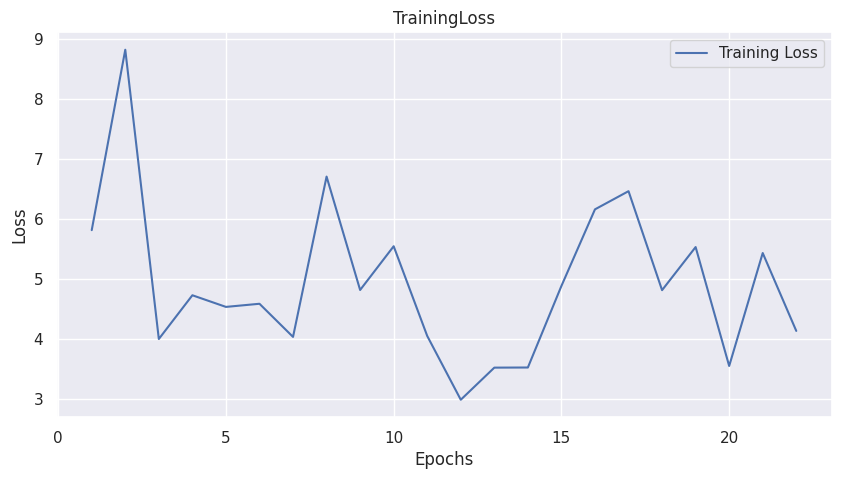

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('TrainingLoss')

Let's plot the validation loss

Text(0.5, 1.0, 'Validation Loss')

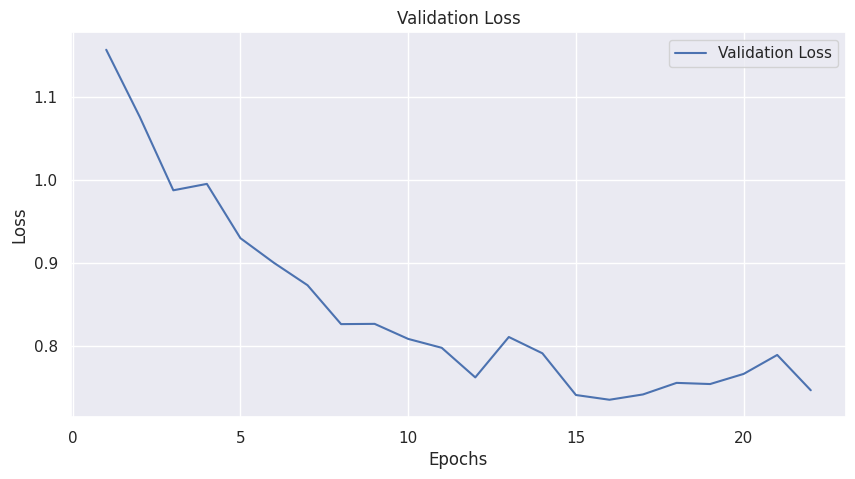

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label= 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss')

Let's save the model so we can use it again:

In [ ]:
from google.colab import files
import shutil

#HDF5-format
model.save('my_model.h5')

files.download('my_model.h5')


#Tensorflow SavedModel-format
#model.save('my_modeltf')
#shutil.make_archive('my_modeltf', 'zip', 'my_modeltf')
#files.download('my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Final Predictions

In [ ]:
print(len(test_df))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(len(sample_submission_df))

214200
(214200, 165, 1)
(214200, 165, 1)
(214200, 1)
214200


In [ ]:
submission_output = model.predict(X_test)

6694/6694 ━━━━━━━━━━━━━━━━━━━━ 268s 40ms/step


In [ ]:
print(submission_output.shape)

(214200, 1)


In [ ]:
# creating dataframe with required columns
submission = pd.DataFrame({'ID':test_df['ID'],'item_cnt_month':submission_output.ravel()})

Let's take a look at the submission
(Be aware 'sample_submission_df' is the demo, 'submission'
 is the real submission)

In [ ]:
print(submission_output)

[[0.27456492]
 [0.22893712]
 [0.27678266]
 ...
 [0.23508044]
 [0.22893712]
 [0.23177153]]


In [ ]:
print(len(submission))
print(len(sample_submission_df))
submission.head()

214200
214200


,ID,item_cnt_month
0,0,0.274565
1,1,0.228937
2,2,0.276783
3,3,0.234462
4,4,0.228937


In [ ]:
# creating csv file from dataframe
submission.to_csv('final_submission.csv',index = False)
